<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# 1. Определение нечеткой базисной функции (треугольная функция)
def create_triangular_fuzzy_basis(nodes, support):
    basis_functions = []
    num_nodes = len(nodes)
    a = nodes[0] - support / 2.0
    b = nodes[-1] + support / 2.0
    grid_points = max(500, int((b-a) * 20))
    x_grid = np.linspace(a, b, grid_points)

    for node in nodes:
        def triangular(x, center, width):
            return np.maximum(0, 1 - np.abs(x - center) / (width / 2.0))
        bf = triangular(x_grid, node, support)
        basis_functions.append(bf)

    return basis_functions, x_grid

# 2. Нормализация базисной функции для разбиения единицы
def normalize_for_partition_of_unity(basis_functions, x_grid):
    # Вычисляем сумму всех базисных функций
    sum_basis = sum(basis_functions)

    # Нормализуем каждую функцию, деля на сумму всех функций
    normalized_funcs = []
    for bf in basis_functions:
        # Избегаем деления на ноль (добавляем небольшое значение)
        normalized = bf / (sum_basis + 1e-10)
        normalized_funcs.append(normalized)

    return normalized_funcs

# 3. Fuzzy Transform (прямое)
def fuzzy_transform(signal_values, x_signal, basis_functions, x_grid):
    Gk_list = []
    for bf in basis_functions:
        bf_interp = np.interp(x_signal, x_grid, bf, left=0, right=0)
        numerator = np.trapz(signal_values * bf_interp, x_signal)
        denominator = np.trapz(bf_interp, x_signal)
        Gk = numerator / denominator if denominator > 0 else 0
        Gk_list.append(Gk)
    return Gk_list

# 4. Inverse Fuzzy Transform (обратное)
def inverse_fuzzy_transform(Gk_list, basis_functions, x_grid):
    approx_signal = np.zeros_like(x_grid)
    for Gk, bf in zip(Gk_list, basis_functions):
        approx_signal += Gk * bf
    return approx_signal

Длина исходного сигнала: 512


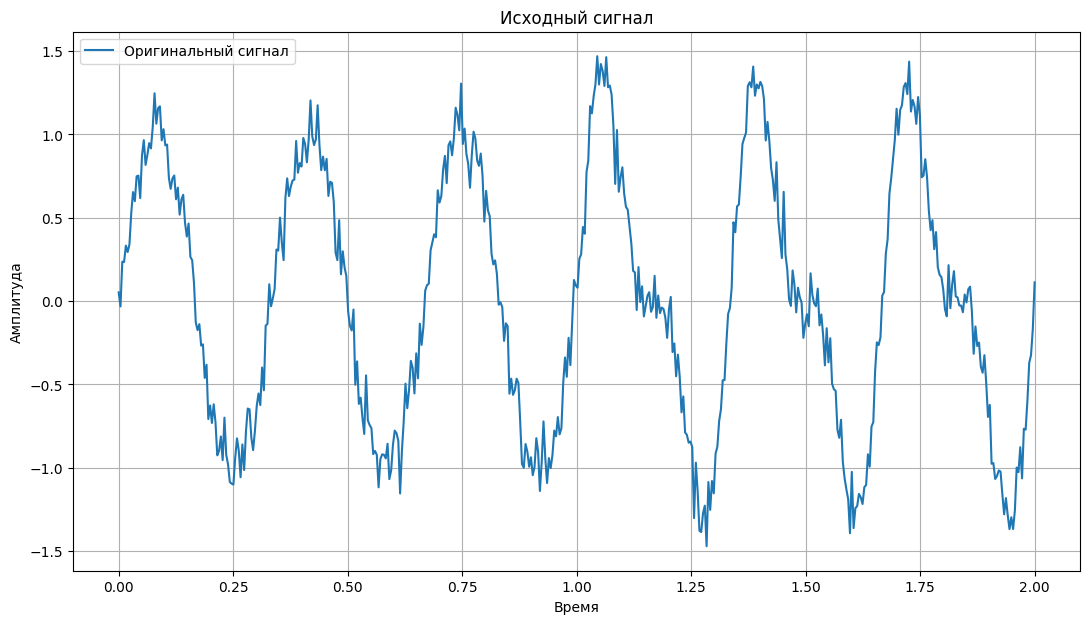

In [3]:
# 1. Создание тестового сигнала
t = np.linspace(0, 2, 512)
original_signal = np.sin(2 * np.pi * 3 * t) + 0.5 * np.heaviside(t - 1, 1)*np.sin(2 * np.pi * 6 * t) + 0.1 * np.random.randn(len(t))
print(f"Длина исходного сигнала: {len(original_signal)}")

# Визуализация исходного сигнала
plt.figure(figsize=(13, 7))
plt.plot(t, original_signal, label='Оригинальный сигнал')
plt.title('Исходный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.show()

Количество узлов: 64, Поддержка: 0.06349206349206349


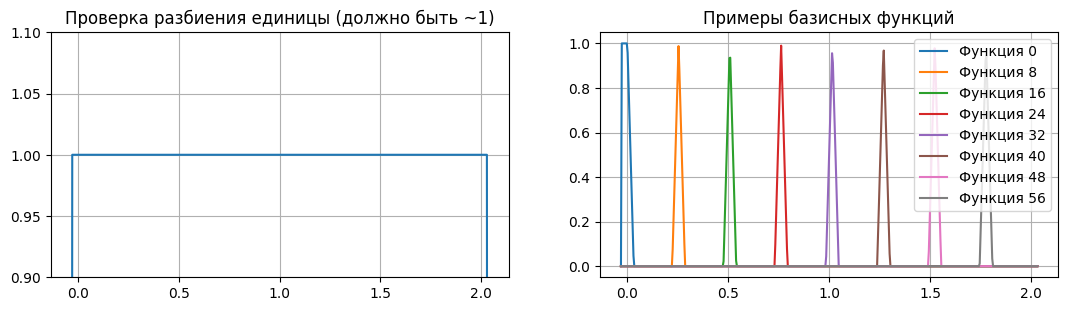

In [4]:
# 2. Определение узлов и базисной функции
num_nodes = 64
nodes = np.linspace(t[0], t[-1], num_nodes)
support = (t[-1] - t[0]) / (num_nodes - 1) * 2
print(f"Количество узлов: {num_nodes}, Поддержка: {support}")

basis_funcs, x_grid_basis = create_triangular_fuzzy_basis(nodes, support)

# 3. Нормализация базисных функций для разбиения единицы
normalized_basis_funcs = normalize_for_partition_of_unity(basis_funcs, x_grid_basis)

# Проверка разбиения единицы
sum_basis = sum(normalized_basis_funcs)

plt.figure(figsize=(13, 7))
plt.subplot(2, 2, 1)
plt.plot(x_grid_basis, sum_basis)
plt.title('Проверка разбиения единицы (должно быть ~1)')
plt.ylim(0.9, 1.1)  # Ограничиваем ось Y для лучшей визуализации
plt.grid(True)

# Визуализация нескольких базисных функций
plt.subplot(2, 2, 2)
for i in range(0, num_nodes, num_nodes//8):  # Показываем каждую 8-ю функцию
    plt.plot(x_grid_basis, normalized_basis_funcs[i], label=f'Функция {i}')
plt.title('Примеры базисных функций')
plt.grid(True)
plt.legend()


/tmp/ipython-input-1143041016.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  numerator = np.trapz(signal_values * bf_interp, x_signal)
/tmp/ipython-input-1143041016.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  denominator = np.trapz(bf_interp, x_signal)


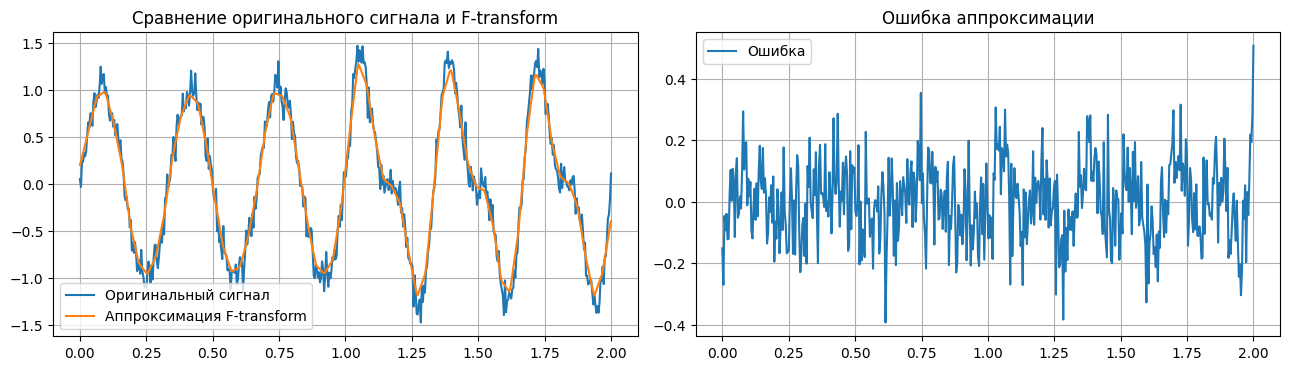


Среднеквадратичная ошибка F-transform: 0.016092


In [5]:
# 4. Прямое Fuzzy-transform
Gk_coeffs = fuzzy_transform(original_signal, t, normalized_basis_funcs, x_grid_basis)
approx_signal_ft = inverse_fuzzy_transform(Gk_coeffs, normalized_basis_funcs, x_grid_basis)

# Интерполяция на исходную сетку
approx_signal_ft_interp = np.interp(t, x_grid_basis, approx_signal_ft)

# Визуализация F-transform
plt.figure(figsize=(13, 7))

plt.subplot(2, 2, 3)
plt.plot(t, original_signal, label='Оригинальный сигнал')
plt.plot(t, approx_signal_ft_interp, label='Аппроксимация F-transform')
plt.title('Сравнение оригинального сигнала и F-transform')
plt.legend()
plt.grid(True)

# Вычисление ошибки
error = original_signal - approx_signal_ft_interp
plt.subplot(2, 2, 4)
plt.plot(t, error, label='Ошибка')
plt.title('Ошибка аппроксимации')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вычисление среднеквадратичной ошибки
mse = np.mean(error**2)
print(f"\nСреднеквадратичная ошибка F-transform: {mse:.6f}")

# пример с гаусоовой функцией

Начало работы с Fuzzy Wavelet (гауссовы функции)...


/tmp/ipython-input-208206818.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  numerator = np.trapz(signal_values * bf_interp, x_signal)
/tmp/ipython-input-208206818.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  denominator = np.trapz(bf_interp, x_signal)


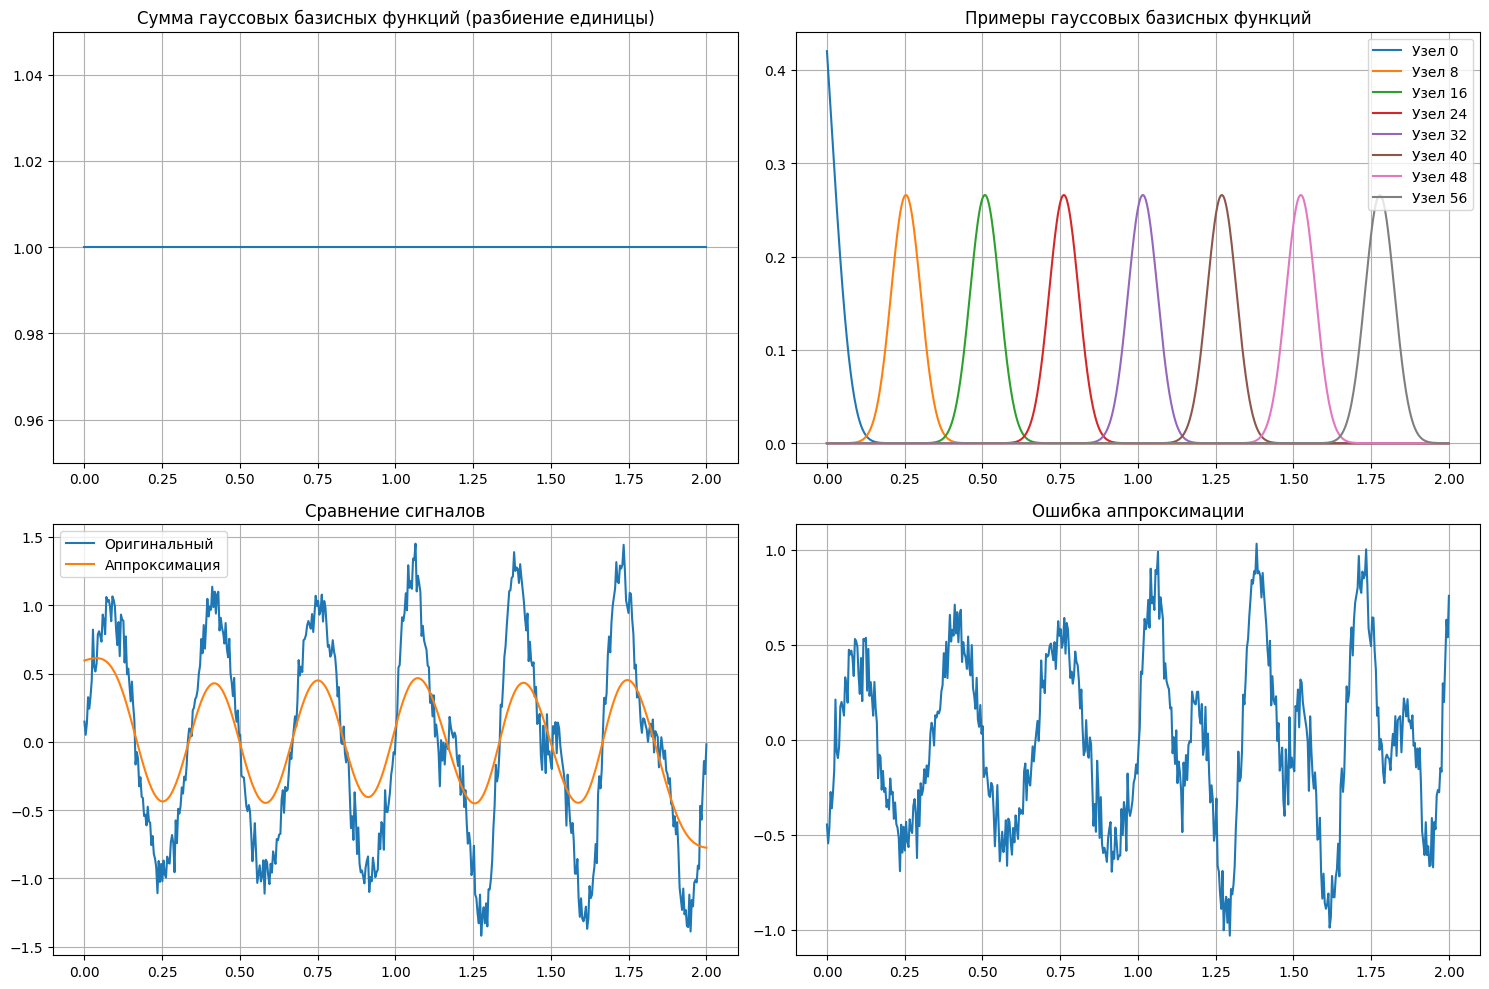

Среднеквадратичная ошибка: 0.202029


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 1. Определение гауссовой базисной функции
def create_gaussian_basis(nodes, sigma, x_grid):
    basis_functions = []
    for node in nodes:
        # Гауссова функция с центром в node и стандартным отклонением sigma
        bf = np.exp(-((x_grid - node)/sigma)**2/2)
        basis_functions.append(bf)
    return basis_functions

# 2. Нормализация для разбиения единицы
def normalize_for_partition_of_unity(basis_functions, x_grid):
    sum_basis = sum(basis_functions)
    normalized_funcs = [bf/(sum_basis + 1e-10) for bf in basis_functions]
    return normalized_funcs

# 3. Fuzzy Transform (прямое)
def fuzzy_transform(signal_values, x_signal, basis_functions, x_grid):
    Gk_list = []
    for bf in basis_functions:
        bf_interp = np.interp(x_signal, x_grid, bf, left=0, right=0)
        numerator = np.trapz(signal_values * bf_interp, x_signal)
        denominator = np.trapz(bf_interp, x_signal)
        Gk = numerator / denominator if denominator > 0 else 0
        Gk_list.append(Gk)
    return Gk_list

# 4. Inverse Fuzzy Transform (обратное)
def inverse_fuzzy_transform(Gk_list, basis_functions, x_grid):
    return sum(Gk * bf for Gk, bf in zip(Gk_list, basis_functions))

# Основной код
print("Начало работы с Fuzzy Wavelet (гауссовы функции)...")

# 1. Создание тестового сигнала
t = np.linspace(0, 2, 512)
original_signal = np.sin(2 * np.pi * 3 * t) + 0.5 * np.heaviside(t - 1, 1)*np.sin(2 * np.pi * 6 * t) + 0.1 * np.random.randn(len(t))

# 2. Определение узлов и параметров гауссовых функций
num_nodes = 64
nodes = np.linspace(t[0], t[-1], num_nodes)
sigma = (t[-1] - t[0])/(num_nodes-1) * 1.5  # Эмпирически подобранный параметр
x_grid_basis = np.linspace(t[0], t[-1], 1000)

# Создание и нормализация базисных функций
basis_funcs = create_gaussian_basis(nodes, sigma, x_grid_basis)
normalized_basis_funcs = normalize_for_partition_of_unity(basis_funcs, x_grid_basis)

# Визуализация
plt.figure(figsize=(15, 10))

# Проверка разбиения единицы
plt.subplot(2, 2, 1)
plt.plot(x_grid_basis, sum(normalized_basis_funcs))
plt.title('Сумма гауссовых базисных функций (разбиение единицы)')
plt.ylim(0.95, 1.05)
plt.grid(True)

# Примеры базисных функций
plt.subplot(2, 2, 2)
for i in range(0, num_nodes, num_nodes//8):
    plt.plot(x_grid_basis, normalized_basis_funcs[i], label=f'Узел {i}')
plt.title('Примеры гауссовых базисных функций')
plt.grid(True)
plt.legend()

# F-transform
Gk_coeffs = fuzzy_transform(original_signal, t, normalized_basis_funcs, x_grid_basis)
approx_signal_ft = inverse_fuzzy_transform(Gk_coeffs, normalized_basis_funcs, x_grid_basis)
approx_signal_ft_interp = np.interp(t, x_grid_basis, approx_signal_ft)

# Сравнение с оригинальным сигналом
plt.subplot(2, 2, 3)
plt.plot(t, original_signal, label='Оригинальный')
plt.plot(t, approx_signal_ft_interp, label='Аппроксимация')
plt.title('Сравнение сигналов')
plt.legend()
plt.grid(True)

# Ошибка аппроксимации
error = original_signal - approx_signal_ft_interp
plt.subplot(2, 2, 4)
plt.plot(t, error)
plt.title('Ошибка аппроксимации')
plt.grid(True)

plt.tight_layout()
plt.show()

# Среднеквадратичная ошибка
mse = np.mean(error**2)
print(f"Среднеквадратичная ошибка: {mse:.6f}")